In [8]:
include("../../src/repeat_testing_scenarios.jl")
using DataFrames
using StatsPlots
using CSV

#model options
VL_model = kissler_model_no 
Inf_model = flat_inf_model_no
onset_opt = PVT_model_opt
peak_inf_opt = unif_peakinf_opt
PCR_sens_max = 0.83 

0.83

In [9]:
Ngen = 10000

10000

In [10]:
sim_non_isol = init_VL_and_infectiousness(Ngen, 0.0)

Dict{String,Any} with 11 entries:
  "will_isolate"       => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, …
  "inf_mag"            => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  … …
  "isolation_time"     => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0…
  "VL_mag"             => [8.20669, 9.39408, 6.2251, 8.64861, 4.9471, 7.61712, …
  "Ntot"               => 10000
  "asymptomatic"       => Bool[1, 1, 1, 1, 1, 0, 0, 1, 1, 0  …  0, 1, 1, 0, 0, …
  "non_isolators"      => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9991, 9992, 9993, …
  "infection_profiles" => [[0.0, 0.0, 0.881259, 0.324404, 0.0], [0.0, 0.0, 0.0,…
  "VL_profiles"        => [[-0.16773, 3.64247, 7.45267, 5.38151, 1.8593], [-0.6…
  "symp_day"           => [1, 3, 2, 2, 1, 4, 3, 6, 4, 4  …  3, 2, 6, 4, 11, 4, …
  "days_infectious"    => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0…

In [11]:
basic_testing_params = Dict{String,Any}("protocol"=>LFD_mass_protocol, "testing_enforced"=>false)

Dict{String,Any} with 2 entries:
  "protocol"         => 2
  "testing_enforced" => false

In [20]:
adherence = collect(0.1:0.1:1.0)
tperiod = collect(1:14)
sim_aon_summary = Array{Dict,2}(undef, length(tperiod), length(adherence))
sim_leaky_summary = Array{Dict,2}(undef, length(tperiod), length(adherence))
for (i,t) in enumerate(tperiod)
    for (j,a) in enumerate(adherence)
        sim_aon = copy(sim_non_isol)
        sim_leaky = copy(sim_non_isol)
        tparams_aon = copy(basic_testing_params)
        tparams_aon["policy_adherence"] = a
        tparams_aon["test_miss_prob"] = 0.0
        tparams_aon["tperiod"] = t
        sim_aon["test_days"], tdc = init_testing!(sim_aon, tparams_aon, 1, 30;
                                  fill_pos_profiles=true, different_start=true)
        sim_aon["test_types"] = 1 .* ones.(Int64,length.(sim_aon["test_days"]))
        sim_aon["conf_PCR"] = zeros.(Bool,length.(sim_aon["test_days"]))
        
        sim_aon["inf_profile_isolation"] = copy.(sim_aon["infection_profiles"])
        sim_aon["test_pos_prob"] = get_test_probs.(sim_aon["VL_profiles"], sim_aon["test_days"], 
                  sim_aon["test_types"]; Do_LFD_test_prob = 1 - tparams_aon["test_miss_prob"]) 
        sim_aon["isol_days"] = run_testing_scenario!.(sim_aon["inf_profile_isolation"],
            sim_aon["infection_profiles"],  sim_aon["test_pos_prob"], sim_aon["test_days"], 
            sim_aon["symp_day"] .+ 1, sim_aon["will_isolate"], sim_aon["VL_profiles"], 
            sim_aon["conf_PCR"])
        sim_aon["inf_profile_isolation"][.!sim_aon["will_isolate_with_test"]] .= 
                copy.(sim_aon["infection_profiles"][.!sim_aon["will_isolate_with_test"]])
        
        
        
        tparams_leaky = copy(basic_testing_params)
        tparams_leaky["policy_adherence"] = 1.0
        tparams_leaky["test_miss_prob"] = 1-a
        tparams_leaky["tperiod"] = t
        sim_leaky["test_days"], tdc = init_testing!(sim_leaky, tparams_leaky, 1, 30;
                                        fill_pos_profiles=true, different_start=true)
        sim_leaky["test_types"] = 1 .* ones.(Int64,length.(sim_leaky["test_days"]))
        sim_leaky["conf_PCR"] = zeros.(Bool,length.(sim_leaky["test_days"]))
        
        sim_leaky["inf_profile_isolation"] = copy.(sim_leaky["infection_profiles"])
        sim_leaky["test_pos_prob"] = get_test_probs.(sim_leaky["VL_profiles"], sim_leaky["test_days"], 
                  sim_leaky["test_types"]; Do_LFD_test_prob = 1 - tparams_leaky["test_miss_prob"]) 
        
        sim_leaky["isol_days"] = run_testing_scenario!.(sim_leaky["inf_profile_isolation"],
            sim_leaky["infection_profiles"],  sim_leaky["test_pos_prob"], sim_leaky["test_days"], 
            sim_leaky["symp_day"] .+ 1, sim_leaky["will_isolate"], sim_leaky["VL_profiles"], 
            sim_leaky["conf_PCR"])
        sim_leaky["inf_profile_isolation"][.!sim_leaky["will_isolate_with_test"]] .= 
                copy.(sim_leaky["infection_profiles"][.!sim_leaky["will_isolate_with_test"]])
        
        sim_aon_summary[i,j] = copy(sim_aon)
        sim_leaky_summary[i,j] = copy(sim_leaky)
    end
end

In [21]:
IPbaseline = sum.(sim_non_isol["infection_profiles"])

df = DataFrame(Scenario=fill("Baseline",Ngen), InfPot = IPbaseline, 
               RPI = zeros(Ngen), Tperiod = fill(Inf,Ngen), Adherence = zeros(Ngen))
for (i,t) in enumerate(tperiod)
    for (j,a) in enumerate(adherence)
        IP_aon = sum.(sim_aon_summary[i,j]["inf_profile_isolation"])
        RPI_aon = 1.0 .- IP_aon./IPbaseline
        dfh = DataFrame(Scenario=fill("AoN",Ngen), InfPot = IP_aon, 
                        RPI = RPI_aon, Tperiod = fill(t,Ngen), Adherence = fill(a,Ngen))
        df = vcat(df,dfh)
        
        IP_leaky = sum.(sim_leaky_summary[i,j]["inf_profile_isolation"])
        RPI_leaky = 1.0 .- IP_leaky./IPbaseline
        dfh = DataFrame(Scenario=fill("Leaky",Ngen), InfPot = IP_leaky, 
                        RPI = RPI_leaky, Tperiod = fill(t,Ngen), Adherence = fill(a,Ngen))
        df = vcat(df,dfh)
    end
end

In [22]:
CSV.write("AoNvsLeaky_demo.csv",df)

"AoNvsLeaky_demo.csv"

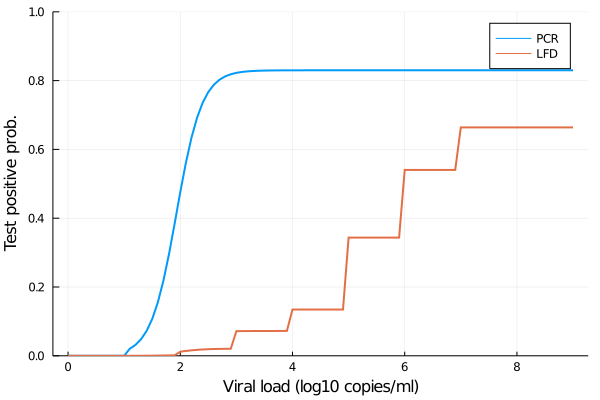

In [58]:
x = 0:0.1:9.0
PCR = PCRtest_positive_prob.(x)
LFD = LFDtest_positive_prob.(x)
plot(x,PCR,linewidth=2,label="PCR",)
plot!(x,LFD,linewidth=2,label="LFD",xlabel="Viral load (log10 copies/ml)", ylabel="Test positive prob.",ylim=(0,1.0))

In [ ]:
print()